<a href="https://colab.research.google.com/github/taravatp/roadLane_InstanceSegmentation/blob/main/generate_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Installations

In [ ]:
cd drive/MyDrive/Lane_Detection/

In [ ]:
!pip install import_ipynb 

In [ ]:
import torch
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

import import_ipynb
from models.model1_TuSimple import Lanenet
from models.ENet_SAD import Enet_SAD

importing Jupyter notebook from /content/drive/MyDrive/Lane_Detection/models/model1_TuSimple.ipynb
importing Jupyter notebook from /content/drive/MyDrive/Lane_Detection/models/ENet_SAD.ipynb


# Loading model

In [ ]:
#model_path = '/content/drive/MyDrive/Lane_Detection/models/trained_models/mymodel4_batch_8.pth'
#model_path = model_path = '/content/drive/MyDrive/Lane_Detection/models/trained_models/SAD_attention_type2/mymodel5_batch_16.pth'
#model_path = '/content/drive/MyDrive/Lane_Detection/models/trained_models/SAD_attention_type3/mymodel5_batch_16.pth'
model_path = '/content/drive/MyDrive/Lane_Detection/models/trained_models/SAD_type2_visualize attention maps/mymodel5_batch_16.pth'
#model_path = '/content/drive/MyDrive/Lane_Detection/models/trained_models/SAD_type3_visualization/mymodel5_batch_16.pth'
#model_path = '/content/drive/MyDrive/Lane_Detection/models/trained_models/SAD_type1_visualization/mymodel5_batch_16.pth'
#model_path = '/content/drive/MyDrive/Lane_Detection/mymodel5_batch_16.pth' #modified and corrected attention generators!
#model_path = '/content/drive/MyDrive/Lane_Detection/models/trained_models/SAD_type2_version2/mymodel5_batch_16.pth'
#model_path = '/content/drive/MyDrive/Lane_Detection/mymodel5_batch_16.pth'

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
test_model = Enet_SAD(2,4).to(device)
test_model.load_state_dict(torch.load(model_path))
print('model loaded!')

model loaded!


# Passing Image through network

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

def process_instance_embedding(instance_embedding, binary_img, distance=1, lane_num=5):
    print('instance embedding size:',instance_embedding.size())
    embedding = instance_embedding[0].detach().numpy().transpose(1, 2, 0)
    print('instance embedding shape:',embedding.shape)
    cluster_result = np.zeros(binary_img.shape, dtype=np.int32)
    cluster_list = embedding[binary_img > 0] #[8155,4] har seri ke run koni ye adade chon model har seri motefavet kar mikonad
    # outputs = np.unique(cluster_list) #[25012,]
    print('cluster list shape:',cluster_list.shape)
    mean_shift = MeanShift(bandwidth=distance, bin_seeding=True, n_jobs=-1)
    mean_shift.fit(cluster_list)
    labels = mean_shift.labels_
    print('labels:',type(labels))
    cluster_result[binary_img > 0] = labels + 1 #tedad jahai ke binary image>0 ast barabar ast ba tedade label haye hasel az clusterin
    #cluster_result[cluster_result > lane_num] = 0
    # print(f"cluster_result shape: {cluster_result.shape}")

    for idx in np.unique(cluster_result):
        if len(cluster_result[cluster_result == idx]) < 50:
            cluster_result[cluster_result == idx] = 0
    H, W = binary_img.shape
    rbg_emb = np.zeros((H, W, 3))
    color = [[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 215, 0], [0, 255, 255]]
    element = np.unique(cluster_result)
    
    
    for i in range(len(element)):
        rbg_emb[cluster_result == element[i]] = color[i]

    return rbg_emb / 255, cluster_result

#rgb_emb, cluster_result = process_instance_embedding(instance_embedding_preds.cpu(), binary_preds, distance=1.5, lane_num=4)


In [ ]:
  test_image_path = '/content/drive/MyDrive/Lane_Detection/TUSMIPLE/training/gt_image/2933.png'
  test_image_original = cv2.imread(test_image_path, cv2.IMREAD_UNCHANGED)
  test_image_original = cv2.cvtColor(test_image_original, cv2.COLOR_RGB2BGR)

  original_shape = test_image_original.shape
  test_image = cv2.resize(test_image_original, dsize=(512,256), interpolation=cv2.INTER_LINEAR)
  test_image = test_image / 127.5 - 1.0
  test_image = np.transpose(test_image, (2, 0, 1))
  test_image = torch.tensor(test_image, dtype=torch.float)
  test_image = test_image.unsqueeze(0).to(device) #we add one more diension which is for batch size

  forward_start = time.time() #start of feedforward
  binary_preds, instance_embedding_preds,loss,at1,at2, at3 = test_model(test_image)
  forward_end = time.time() #end of feedforward
  binary_preds = torch.argmax(binary_preds, dim=1).squeeze().cpu().numpy() #Returns the indices of the maximum value of all elements in the input tensor.

  #binary_preds[0:50,:] = 0

  cluster_start = time.time()
  rgb_emb, cluster_result = process_instance_embedding(instance_embedding_preds.cpu(), binary_preds, distance=1.5, lane_num=4)
  cluster_end = time.time()

  cluster_result = cv2.resize(cluster_result, dsize=(original_shape[1], original_shape[0]), interpolation=cv2.INTER_NEAREST)
  print('here')
  print(cluster_result.shape)

torch.Size([1, 128, 32, 64])
torch.Size([1, 128, 32, 64])
torch.Size([1, 64, 64, 128])
inja
tensor(9.3043, device='cuda:0', grad_fn=<MaxBackward1>)
inja
[0 1]
instance embedding size: torch.Size([1, 4, 256, 512])
instance embedding shape: (256, 512, 4)
cluster list shape: (7350, 4)
labels: <class 'numpy.ndarray'>
here
(720, 1280)


# Visualizations

(256, 512)


Text(0.5, 1.0, 'final prediction')

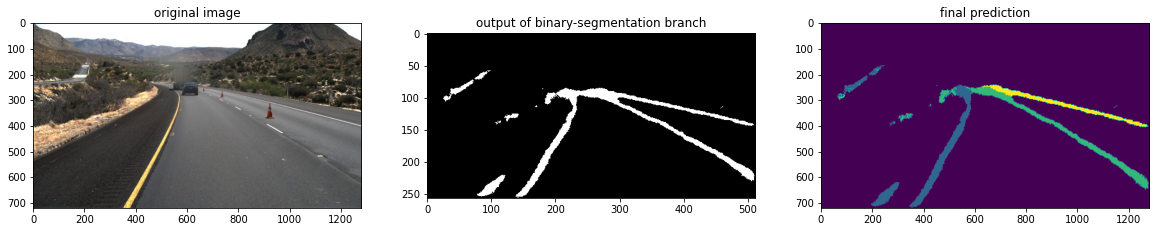

In [ ]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(131)
plt.imshow(test_image_original)
plt.title('original image')
ax1 = plt.subplot(132)
plt.imshow(binary_preds,cmap='gray')
plt.title('output of binary-segmentation branch')
ax1 = plt.subplot(133)
plt.imshow(cluster_result)
plt.title('final prediction')

In [ ]:
at1 = at1.to('cpu')
at2 = at2.to('cpu')
at3 = at3.to('cpu')

at1 = at1[0].detach().numpy()
at2 = at2[0].detach().numpy()
at3 = at3[0].detach().numpy()

In [ ]:
print(at1.shape)
print(at2.shape)
print(at3.shape)

Text(0.5, 1.0, 'attention 3')

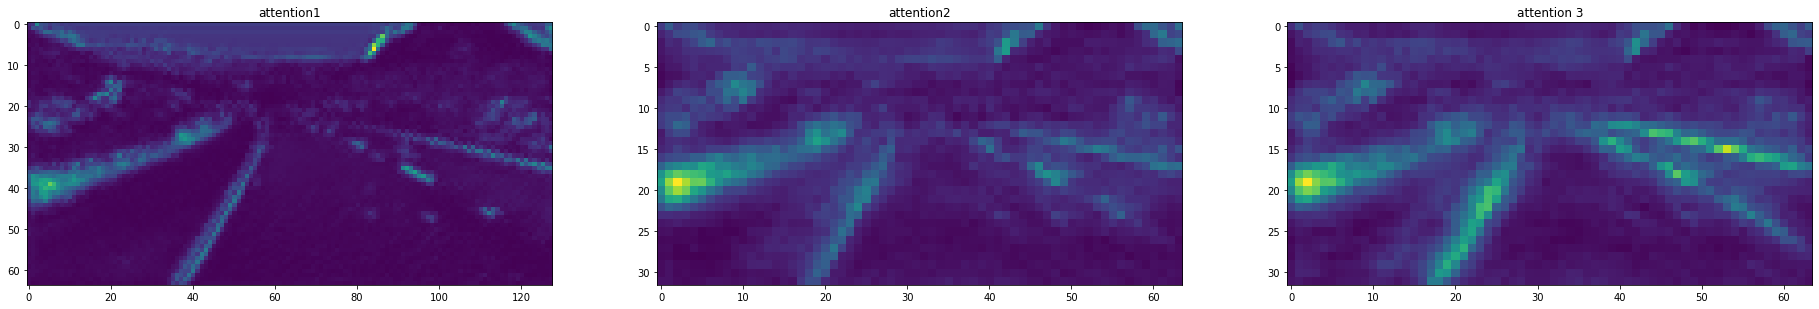

In [ ]:

plt.figure(figsize=(32,48))
ax1 = plt.subplot(131)
plt.imshow(at1)
plt.title('attention1')
ax1 = plt.subplot(132)
plt.imshow(at2)
plt.title('attention2')
ax1 = plt.subplot(133)
plt.imshow(at3)
plt.title('attention 3')

In [ ]:
plt.figure(figsize=(20,10))

In [ ]:
instance_embedding_preds = instance_embedding_preds.cpu().detach().numpy()

(1, 4, 256, 512)


Text(0.5, 1.0, 'embedding output 3')

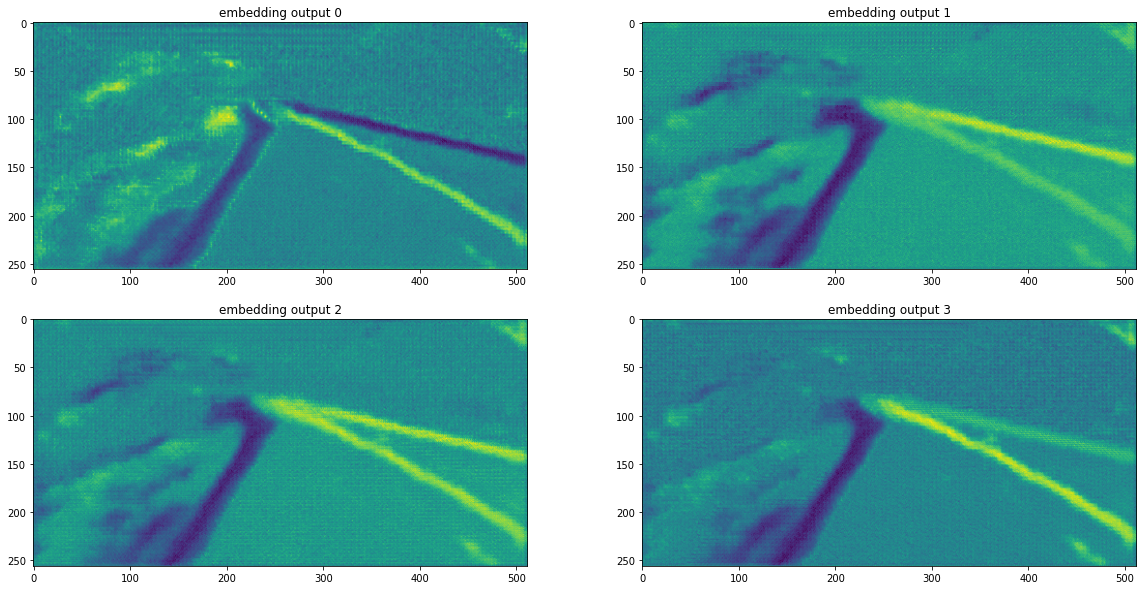

In [ ]:
print(instance_embedding_preds.shape)
plt.figure(figsize=(20,10))
ax1 = plt.subplot(221)
plt.imshow(instance_embedding_preds[0,0,:,:])
plt.title('embedding output 0')
ax1 = plt.subplot(222)
plt.imshow(instance_embedding_preds[0,1,:,:])
plt.title('embedding output 1')
ax1 = plt.subplot(223)
plt.imshow(instance_embedding_preds[0,2,:,:])
plt.title('embedding output 2')
ax1 = plt.subplot(224)
plt.imshow(instance_embedding_preds[0,3,:,:])
plt.title('embedding output 3')

In [ ]:
print(instance_embedding_preds[0,0,:,:].shape)

torch.Size([256, 512])
